In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import teotil3 as teo
import utils
from sqlalchemy import text

plt.style.use("ggplot")

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Create point source input files for OF800

Phil has estimated riverine nutrient fluxes using kernel smoothing for the main monitoring points on each river around Oslofjorden. This notebook identifies point sources (industry and wastewater) downstream of these locations, so Phil can include them as point sources in the OF800  model.

## 1.Identify point sources downstream of monitoring points

Find point sources downstream of water chemistry sampling points on the "main" rivers.

In [4]:
# Period of interest
st_yr, end_yr = 2017, 2019

# Vassdragsområder of interest
vassom_min, vassom_max = 1, 17

# Point sources to consider. Aquaculture is negligible in vassoms 001 to 017
sectors = ["large wastewater", "industry"]

# Scenarios to consider
scens = ["Baseline", "Scenario_A", "Scenario_B"]

# Percentage overflow for each scenario
overflow_dict = {"Baseline": 2, "Scenario_A": 2, "Scenario_B": 1}

# Define min capacity for sites with overflows (in p.e.)
overflow_thresh = 1000

# TEOTIL pars
pars = ["totn", "din", "ton", "totp", "tdp", "tpp", "toc", "ss"]

# Regines used by Leah for chem monitoring sites
xl_path = r"../data/leah_oslomod_main_rivs.xlsx"

# Container for results
res_dict = {}

In [5]:
# Read Leah's file mapping monitoring sites to regines
loc_df = pd.read_excel(xl_path)
loc_df

,id,name,lat,lon,regine,vassom
0,6,Tista,59.119,11.370,001.A1,1
1,7,Glomma,59.206,10.953,002.A51,2
2,8,Mosseelva,59.439,10.662,003.A1,3
3,9,Hølenelva,59.523,10.690,004.A0,4
4,10,Årungen,59.720,10.728,005.3A,5
5,11,Akerselva,59.908,10.756,006.A10,6
6,12,Lysakerelva,59.914,10.640,007.A0,7
7,13,Sandvikselva,59.890,10.523,008.A11,8
8,14,Åros,59.704,10.519,009.A0,9
9,15,Tofteelva,59.547,10.568,010.2Z,10


In [6]:
# Get regine spatial data and build network graph
reg_gdf = teo.io.get_regine_geodataframe(eng, 2023)
reg_gdf = teo.io.assign_regine_hierarchy(
    reg_gdf,
    regine_col="regine",
    regine_down_col="regine_down",
    order_coastal=False,
    nan_to_vass=True,
    land_to_vass=True,
    add_offshore=True,
)
g = teo.model.build_graph(reg_gdf, id_col="regine", next_down_col="regine_down")

100.00 % of regines assigned.


In [7]:
# Single polygon for whole Oslofjord catchment
reg_gdf["vassom_int"] = reg_gdf["vassom"].astype(int)
osl_gdf = reg_gdf.query("@vassom_min <= vassom_int <= @vassom_max").copy()
osl_gdf["dissolve"] = 1
osl_gdf = osl_gdf.dissolve(by="dissolve")

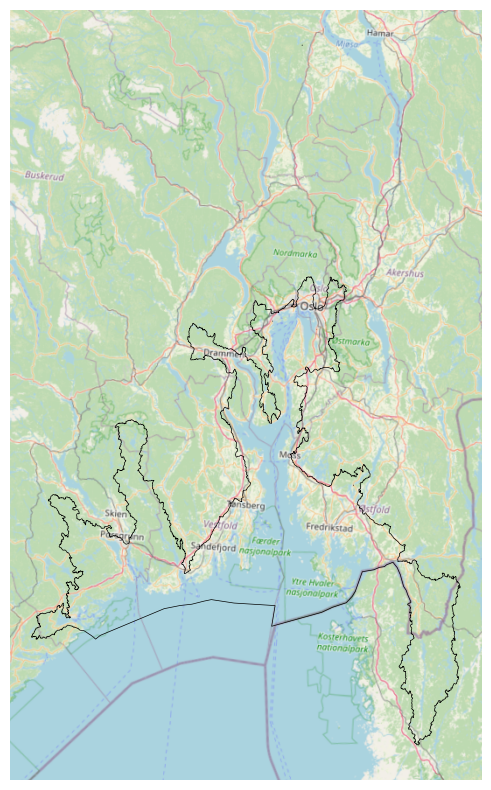

In [8]:
# Get polys upstream of each monitoring point
gdf_list = []
for idx, row in loc_df.iterrows():
    site_name = row["name"]
    reg_id = row["regine"]
    gdf, ax = teo.vis.plot_catchment(
        g, reg_id, reg_gdf, id_col="regine", include_connected=True, direct="up"
    )
    plt.close()
    gdf["name"] = site_name
    gdf = gdf[["regine", "name", "geometry"]]

    gdf_list.append(gdf)
gdf = pd.concat(gdf_list, axis="rows")

# Merge monitored catchments to a single poly
upstr_gdf = gdf.copy()
upstr_gdf["dissolve"] = 1
upstr_gdf = upstr_gdf.dissolve(by="dissolve")

# Subtract from whole Oslofjord catchment to get downstream part
downstr_gdf = osl_gdf.overlay(upstr_gdf, how="difference")

# Plot downstream catchment
ax = downstr_gdf.plot(color="none", edgecolor="black", figsize=(10, 10))
cx.add_basemap(
    ax,
    crs=downstr_gdf.crs.to_string(),
    source=cx.providers.OpenStreetMap.Mapnik,
    attribution=False,
)
ax.axis("off");

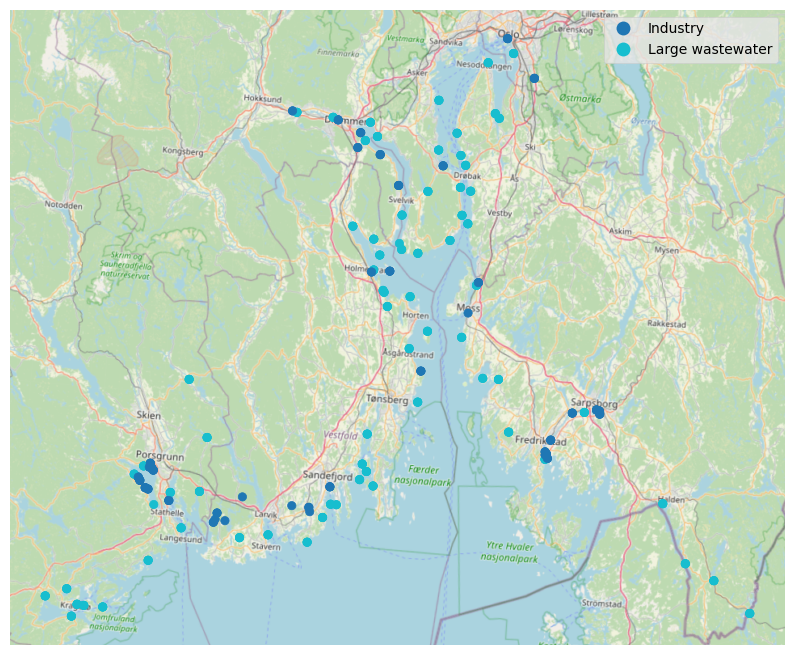

In [9]:
# Get point sources from TEOTIL database
df_list = []
for year in range(st_yr, end_yr + 1):
    for sector in sectors:
        pt_df = teo.io.get_raw_annual_point_data(
            eng,
            year,
            sector,
            par_list=[
                "totn_kg",
                "din_kg",
                "ton_kg",
                "totp_kg",
                "tdp_kg",
                "tpp_kg",
                "toc_kg",
                "ss_kg",
            ],
        )
        df_list.append(pt_df)
pt_df = pd.concat(df_list, axis="rows")

# Build point source gdf
pt_gdf = gpd.GeoDataFrame(
    pt_df,
    geometry=gpd.points_from_xy(pt_df["outlet_x_utm33"], pt_df["outlet_y_utm33"]),
    crs="epsg:25833",
)

# Get point sources within the downstream area
downstr_pt_gdf = gpd.sjoin(
    pt_gdf, downstr_gdf[["vassom", "geometry"]], predicate="within"
)
downstr_pt_gdf = downstr_pt_gdf[pt_gdf.columns]

# Add lat and lon
downstr_pt_gdf["outlet_lat"] = downstr_pt_gdf.to_crs("epsg:4326").geometry.y
downstr_pt_gdf["outlet_lon"] = downstr_pt_gdf.to_crs("epsg:4326").geometry.x

# Plot
ax = downstr_pt_gdf.plot(column="sector", legend=True, figsize=(10, 10))
# downstr_gdf.plot(ax=ax, color="none", edgecolor="black")
cx.add_basemap(
    ax,
    crs=downstr_gdf.crs.to_string(),
    source=cx.providers.OpenStreetMap.Mapnik,
    attribution=False,
)
ax.axis("off");

In [10]:
downstr_pt_gdf.head()

,site_id,site_name,sector,type,site_x_utm33,site_y_utm33,outlet_x_utm33,outlet_y_utm33,year,regine,...,SS_kg,TDP_kg,TOC_kg,TON_kg,TOTN_kg,TOTP_kg,TPP_kg,geometry,outlet_lat,outlet_lon
0,0301.0979.01,Bekkelaget renseanlegg med tilførselstuneller ...,Large wastewater,Kjemisk-biologisk m/N-fjerning,263347.073035,6.646048e+06,262704.276918,6.645807e+06,2017,006.21,...,375794.5,6193.5,343369.7,95623.0,398429.1,13763.3,7569.8,POINT (262704.277 6645806.588),59.881414,10.758925
863,3101.0051.01,Prestebakke,Large wastewater,Biologisk,301383.130803,6.543874e+06,301405.296531,6.543897e+06,2017,001.1A2B,...,1286.2,76.9,5510.8,172.0,1322.9,174.7,97.8,POINT (301405.297 6543897.407),58.988405,11.543490
864,3101.0052.01,Bakke (Nedlagt),Large wastewater,Kjemisk-biologisk,295950.748421,6.547185e+06,295895.605980,6.547175e+06,2017,001.2220,...,13487.7,4.4,9665.2,84.2,841.5,34.0,29.6,POINT (295895.606 6547175.329),59.015194,11.444774
865,3101.0054.01,Kornsjø,Large wastewater,Kjemisk-biologisk,308388.496555,6.537612e+06,308347.248183,6.537567e+06,2017,001.1J,...,1715.7,6.0,1186.7,66.2,661.9,46.5,40.5,POINT (308347.248 6537566.641),58.934812,11.669556
866,3101.0055.01,Remmendalen avløpsanlegg,Large wastewater,Kjemisk-biologisk,291726.785370,6.559128e+06,291532.153379,6.558785e+06,2017,001.310,...,115444.9,204.9,76209.8,8598.0,85980.2,1576.4,1371.5,POINT (291532.153 6558784.914),59.117139,11.357928


## 2. Data for industrial sites

Industrial discharges are not affected by the scenarios, so I will just create a single worksheet (`coastal_industry_baseline`) that can be used for all three scenarios.

Note that the workflow below is a bit fiddly, because Phil is interested in parameters other than just the standard ones in TEOTIL3 (BOF5 and KOF). The code below gets raw data for these variables and includes it alongside the merged TEOTIL3 estimates.

In [11]:
# Read raw industrial data for all sites
raw_pars = [
    "BOF5",
    "KOF",
    "TOC",
]
df_list = []
for year in range(st_yr, end_yr + 1):
    xl_path = (
        f"/home/jovyan/shared/common/teotil3/point_data/{year}/industry_{year}_raw.xlsx"
    )
    df = (
        pd.read_excel(xl_path)
        .dropna(subset=["Anleggsnr", "Komp.kode", "Enhet", "Mengde"])
        .query("`Komp.kode` in @raw_pars")
    )
    assert (df["Enhet"] == "tonn").all()
    df = df[["Anleggsnr", "Komp.kode", "Mengde"]]
    df.columns = ["site_id", "par", "value"]
    df["value"] = df["value"] * 1000
    df["par"] = df["par"] + "_Raw_kg"
    df = df.set_index(["site_id", "par"]).unstack("par")
    df.columns = df.columns.get_level_values(1)
    df.columns.name = ""
    df = df.reset_index()
    df["year"] = year
    df_list.append(df)
raw_ind_df = pd.concat(df_list, axis="rows")
raw_ind_df.head()

,site_id,BOF5_Raw_kg,KOF_Raw_kg,TOC_Raw_kg,year
0,1101.0004.01,25000.0,NaN,NaN,2017
1,1101.0017.01,233000.0,NaN,77000.0,2017
2,1103.0595.01,50705.7,NaN,22095.2,2017
3,1124.0016.01,NaN,NaN,370.2,2017
4,1133.0002.02,NaN,830000.0,110700.0,2017


In [12]:
# Get just sites of interest around Oslofjord coast
ind_df = downstr_pt_gdf.query("sector == 'Industry'").drop(columns="geometry")
ind_df = pd.merge(ind_df, raw_ind_df, how="left", on=["site_id", "year"])
val_cols = sorted([col for col in ind_df.columns if col.endswith("_kg")])
id_cols = [
    "site_id",
    "site_name",
    "sector",
    "type",
    "outlet_lon",
    "outlet_lat",
    "year",
]
ind_df = ind_df[id_cols + val_cols]
ind_df = ind_df.rename(columns={"site_id": "anlegg_nr", "site_name": "anlegg_name"})
ind_df = ind_df.sort_values(["anlegg_nr", "year"])

# Convert to tonnes
for col in ind_df.columns:
    if col.endswith("_kg"):
        new_col = col.replace("_kg", "_tonnes")
        ind_df[new_col] = (ind_df[col] / 1000).round(3)
        del ind_df[col]

# Add to results
res_dict["coastal_industry_baseline"] = ind_df

ind_df.head()

,anlegg_nr,anlegg_name,sector,type,outlet_lon,outlet_lat,year,BOF5_Raw_tonnes,DIN_tonnes,KOF_Raw_tonnes,SS_tonnes,TDP_tonnes,TOC_Raw_tonnes,TOC_tonnes,TON_tonnes,TOTN_tonnes,TOTP_tonnes,TPP_tonnes
0,0301.0430.01,Hafslund Oslo Celsio AS avd Klemetsrudveien,Industry,Avfallsforbrenning,10.835762,59.840625,2017,NaN,NaN,NaN,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,0301.0430.01,Hafslund Oslo Celsio AS avd Klemetsrudveien,Industry,Avfallsforbrenning,10.835762,59.840625,2018,NaN,NaN,NaN,0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,0301.0430.01,Hafslund Oslo Celsio AS avd Klemetsrudveien,Industry,Avfallsforbrenning,10.835762,59.840625,2019,NaN,NaN,NaN,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0301.1231.01,NCC Norge - Snøsmelteanlegg ved Grønlia i Oslo,Industry,Annen aktivitet,10.734941,59.906422,2017,NaN,NaN,NaN,1.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,0301.1231.01,NCC Norge - Snøsmelteanlegg ved Grønlia i Oslo,Industry,Annen aktivitet,10.734941,59.906422,2018,NaN,NaN,NaN,126.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Data for wastewater sites

The code below reads the scenario input files generated in notebook 01, but processes them a little to separate overflows from main discharges, as requested by Phil (see e-mail received 31.10.2025 at 20:04).

In [13]:
ww_pars = ["bof5", "kof", "ss", "totn", "totp"]
ww_ids = (
    downstr_pt_gdf.query("sector == 'Large wastewater'")["site_id"].unique().tolist()
)
for scen in scens:
    df_list = []
    for year in range(st_yr, end_yr + 1):
        xl_path = f"/home/jovyan/shared/common/oslofjord_modelling/phase3_scenarios/teotil3_input_files/{scen}/{year}/large_wastewater_{year}_raw.xlsx"
        df = pd.read_excel(xl_path).query("anlegg_nr in @ww_ids")

        # Patch NaN in outlet co-ords with site co-ords
        df["outlet_zone"] = df["outlet_zone"].fillna(df["site_zone"])
        df["outlet_east"] = df["outlet_east"].fillna(df["site_east"])
        df["outlet_north"] = df["outlet_north"].fillna(df["site_north"])

        # Add lat/lon for outlet
        df["outlet_zone"] = df["outlet_zone"].astype(int)
        df = nivapy.spatial.utm_to_wgs84_dd(
            df, zone="outlet_zone", east="outlet_east", north="outlet_north"
        )

        # Sites with overflow
        site_list = (
            df.query("current_capacity >= @overflow_thresh")["anlegg_nr"]
            .unique()
            .tolist()
        )

        # Estimate overflows
        of_pct = overflow_dict[scen]
        for par in ww_pars:
            df[f"{par}_overflow_tonnes"] = of_pct * df[f"{par}_in_tonnes"] / 100
            df[f"{par}_overflow_tonnes"] = df[f"{par}_overflow_tonnes"].fillna(0)
            df.loc[~df["anlegg_nr"].isin(site_list), f"{par}_overflow_tonnes"] = 0
            df[f"{par}_out_tonnes"] = (
                df[f"{par}_out_tonnes"] - df[f"{par}_overflow_tonnes"]
            )
            del df[f"{par}_in_tonnes"]
        df_list.append(df)
    ww_df = pd.concat(df_list, axis="rows")
    val_cols = sorted([col for col in ww_df.columns if col.endswith("_tonnes")])
    id_cols = [
        "anlegg_nr",
        "kilderefnr",
        "anlegg_name",
        "type",
        "lat",
        "lon",
        "current_capacity",
        "year",
    ]
    ww_df = ww_df[id_cols + val_cols]
    ww_df[val_cols] = ww_df[val_cols].round(3)
    ww_df = ww_df.rename(columns={"current_capacity": "capacity"})
    ww_df = ww_df.sort_values(["anlegg_nr", "year"])

    # Add to results
    res_dict[f"coastal_wastewater_{scen.lower()}"] = ww_df

In [14]:
# Save
with pd.ExcelWriter(r"../data/of800_downstream_point_sources_2017-19.xlsx") as writer:
    for sheet, df in res_dict.items():
        df.to_excel(writer, sheet_name=sheet, index=False)